<a href="https://colab.research.google.com/github/ArturGogiyan/NLP_research/blob/master/NLP_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv('/content/drive/MyDrive/datasets/dataset_research.csv') 

print("Shape of data=>",df.shape)

Shape of data=> (5000, 6)


# Exploratory data analysis

Создание списка всех лейблов, присутствующих в данных

In [4]:
comment_labels = {}
comment_labels_combinations = {}
unique_labels = set()
unique_labels_combinations = set()

for i, row in df.iterrows():
    label_index = 0
    k = 0
    for j, cell in row.items():
        if str(cell)[:6] == '[\'824.':
            label_index = k
            break
        k+=1


    labels = row[k][1:-1].split(',')

    comment = ' '.join(row[:k])
    row['comment'] = comment
    for j, label in enumerate(labels):
        label_stripped = label.strip()[5:-3]
        labels[j] = label_stripped
        if label_stripped not in unique_labels:
            unique_labels.add(label_stripped)
    labels_combination = ' & '.join(labels)
    if labels_combination not in unique_labels_combinations:
       unique_labels_combinations.add(labels_combination)
    comment_labels[i] = labels
    comment_labels_combinations[i] = labels_combination

создание pandas.dataframe с разреженным вектором фич, где каждая колонка - отдельный лэйбл

In [5]:
df_unique_combinations = df[['comment']].copy()
for label in unique_labels:
  df[label] = 0
for label_combination in unique_labels_combinations:
  df_unique_combinations[label_combination] = 0

In [6]:
df = df.drop(df.columns[[1, 2, 3, 4, 5]], axis=1)

In [7]:
for index, labels in comment_labels.items():
  for label in labels:
    df.at[index, label] = 1

for index, label_combination in comment_labels_combinations.items():
  for label in label_combination:
    df_unique_combinations.at[index, label_combination] = 1

вывод первых 5 записей отформатированного датафрейма

In [8]:
df.head(5)

,comment,company-brand.general-satisfaction,attributes.taste-flavour,company-brand.convenience,attributes.size-fit,account-management.account-access,company-brand.competitor,attributes.cleanliness,online-experience.language,staff-support.email,staff-support.agent-named,purchase-booking-experience.choice-variety,logistics-rides.speed,logistics-rides.order-accuracy,account-management.fingerprint-facial-recognition,online-experience.updates-versions
0,"easy, very accessible",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Just a horrible app with a sign up experience ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Downloaded the latest update and it still logs...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,Since latest update from Apple for the iPhone ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,"Shockingly bad since the update, I had to rein...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
df_unique_combinations.head(5)

,comment,company-brand.general-satisfaction & company-brand.convenience,account-management.account-access & company-brand.convenience,company-brand.general-satisfaction,company-brand.general-satisfaction & online-experience.language,account-management.fingerprint-facial-recognition & company-brand.convenience,company-brand.convenience & purchase-booking-experience.choice-variety,company-brand.general-satisfaction & online-experience.updates-versions,online-experience.language,staff-support.email,attributes.size-fit & online-experience.updates-versions,company-brand.general-satisfaction & purchase-booking-experience.choice-variety,online-experience.updates-versions,account-management.account-access & company-brand.competitor,staff-support.agent-named,company-brand.convenience,account-management.fingerprint-facial-recognition & account-management.account-access & company-brand.convenience,attributes.size-fit,company-brand.convenience & online-experience.updates-versions,account-management.account-access & online-experience.updates-versions,account-management.fingerprint-facial-recognition & company-brand.general-satisfaction,company-brand.competitor,attributes.cleanliness,company-brand.general-satisfaction & logistics-rides.speed,company-brand.convenience & company-brand.general-satisfaction,company-brand.general-satisfaction & staff-support.email,company-brand.general-satisfaction & company-brand.competitor & purchase-booking-experience.choice-variety,attributes.size-fit & company-brand.general-satisfaction,logistics-rides.speed & purchase-booking-experience.choice-variety,logistics-rides.order-accuracy,company-brand.general-satisfaction & company-brand.competitor & online-experience.updates-versions,account-management.account-access & company-brand.general-satisfaction & company-brand.competitor,account-management.fingerprint-facial-recognition & account-management.account-access & online-experience.updates-versions,account-management.fingerprint-facial-recognition & online-experience.updates-versions,account-management.fingerprint-facial-recognition & account-management.account-access,company-brand.competitor & online-experience.updates-versions,purchase-booking-experience.choice-variety,company-brand.general-satisfaction & company-brand.competitor,account-management.account-access & company-brand.convenience & online-experience.updates-versions,account-management.fingerprint-facial-recognition & account-management.account-access & company-brand.general-satisfaction,attributes.taste-flavour,account-management.account-access,account-management.account-access & company-brand.general-satisfaction,company-brand.competitor & company-brand.general-satisfaction,company-brand.convenience & company-brand.competitor,account-management.account-access & company-brand.general-satisfaction & online-experience.updates-versions,logistics-rides.speed,account-management.fingerprint-facial-recognition
0,"easy, very accessible",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Just a horrible app with a sign up experience ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Downloaded the latest update and it still logs...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Since latest update from Apple for the iPhone ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,"Shockingly bad since the update, I had to rein...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Посмотрим на количество пустых полей в датасете

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   comment                                            5000 non-null   object
 1   company-brand.general-satisfaction                 5000 non-null   int64 
 2   attributes.taste-flavour                           5000 non-null   int64 
 3   company-brand.convenience                          5000 non-null   int64 
 4   attributes.size-fit                                5000 non-null   int64 
 5   account-management.account-access                  5000 non-null   int64 
 6   company-brand.competitor                           5000 non-null   int64 
 7   attributes.cleanliness                             5000 non-null   int64 
 8   online-experience.language                         5000 non-null   int64 
 9   staff-support.email

Получим частоты лейблов в датасете

In [11]:
feature_freqs =  df.sum(axis = 0, skipna = True)[1:].sort_values(ascending=True)

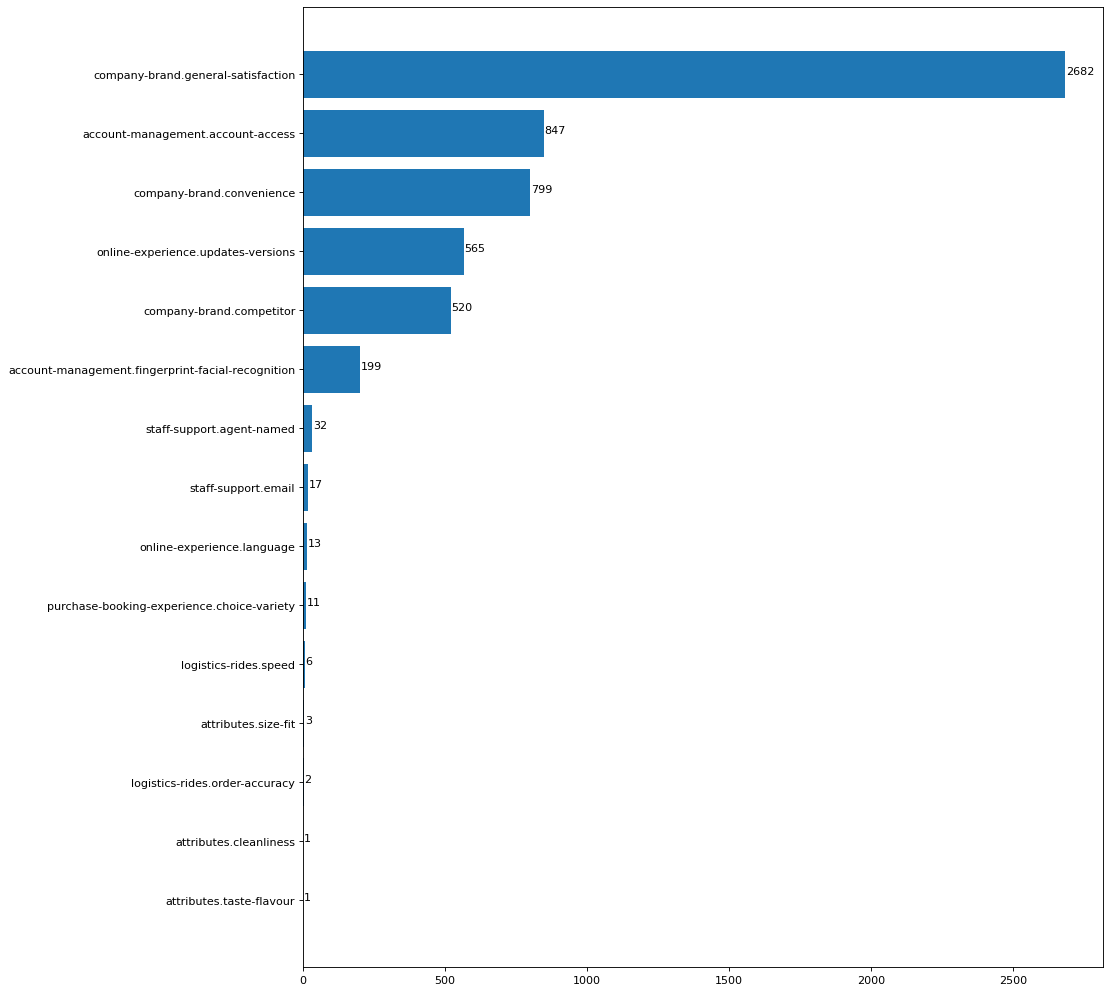

In [12]:
fig = plt.figure(figsize=(10, 12), dpi=80)
plt.xlabel('feature')
plt.ylabel('frequency')
plt.title('frequency of different features in applied dataset')

ax = fig.add_axes([0,0,1,1])
ax.barh(feature_freqs.keys(),feature_freqs.values)

xlocs, xlabs = plt.xticks()
for i, v in enumerate(feature_freqs.values):
    ax.text(v + 3, i, str(v))

plt.show()

как видно, датасет не сбалансирован: для некоторых лэйблов существует лишь по несколько записей.
К примеру, лэйблы **attributes.cleanliness** и **attributes.taste-flavour** представленны лишь в 1 записи.

Рассмотрим распределение комментариев по сочетаниям лейблов

In [13]:
feature_freqs_combinations =  df_unique_combinations.sum(axis = 0, skipna = True)[1:].sort_values(ascending=True)

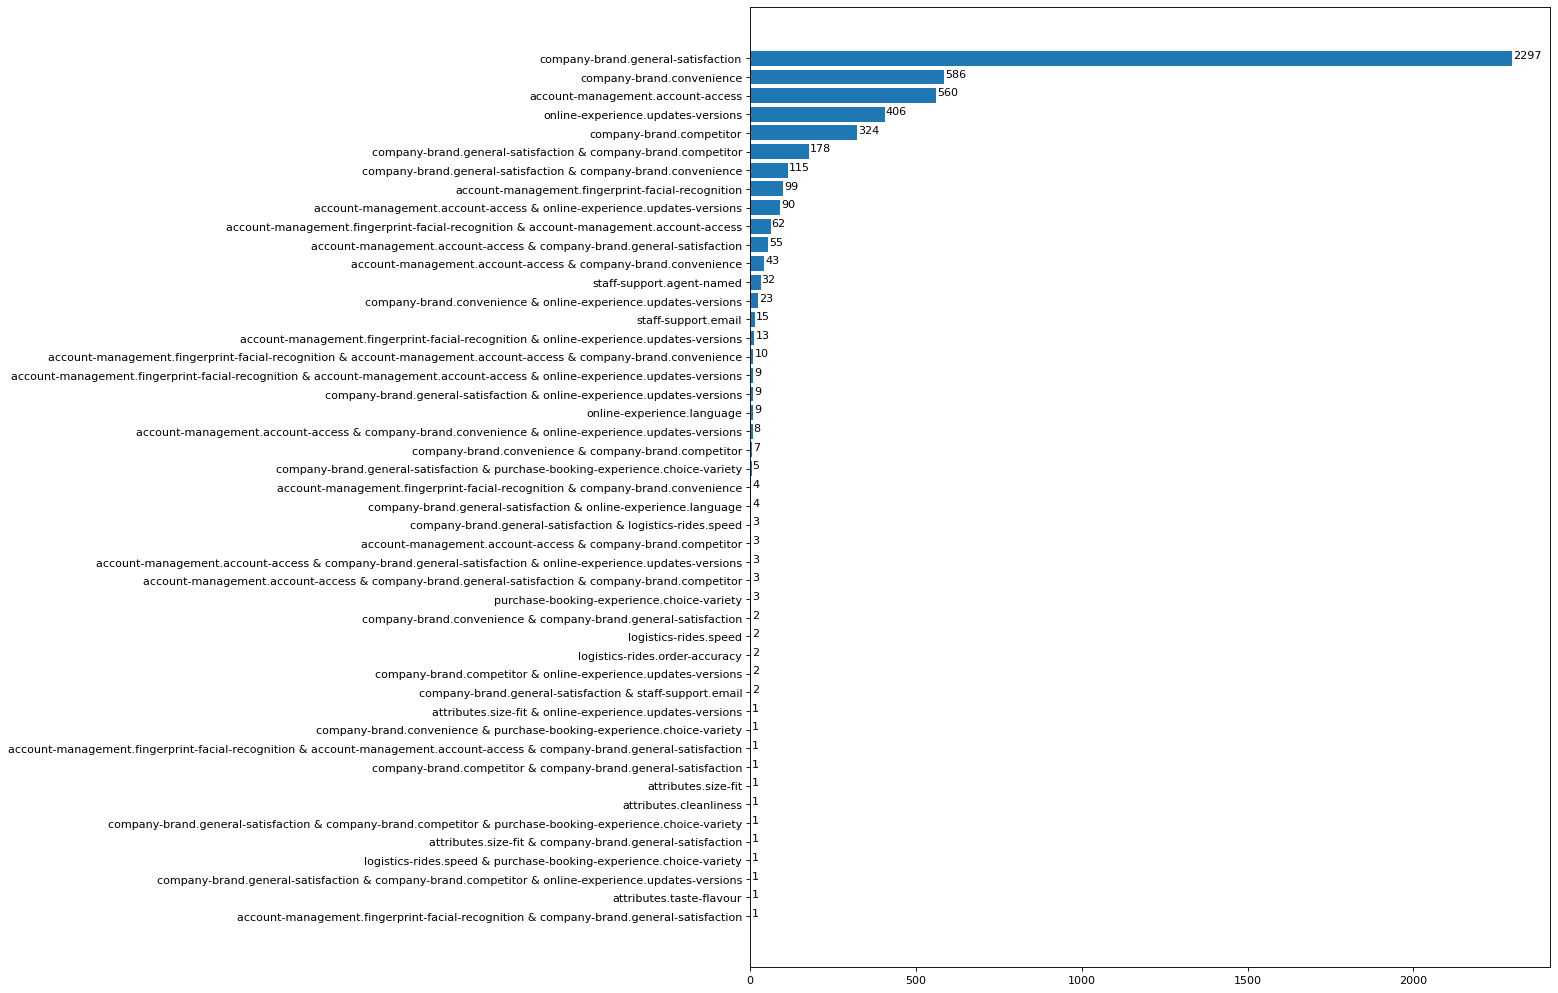

In [14]:
fig = plt.figure(figsize=(10, 12), dpi=80)
plt.xlabel('feature')
plt.ylabel('frequency')
plt.title('frequency of different features in applied dataset')

ax = fig.add_axes([0,0,1,1])
ax.barh(feature_freqs_combinations.keys(),feature_freqs_combinations.values)

xlocs, xlabs = plt.xticks()
for i, v in enumerate(feature_freqs_combinations.values):
    ax.text(v + 3, i, str(v))

plt.show()

# Non-neural network processing

## Preparations

Resources needed:

In [71]:
import nltk
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets, metrics, model_selection, svm
import xgboost as xgb
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
%matplotlib inline
nltk.download('wordnet')
minimum_classes = 0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Lemmatization

In [72]:
def make_lemmas(tokens):
    return ' '.join(list(map(lambda t: lemmatizer.lemmatize(t), tokens)))
def preprocess(text):
    return re.findall(re.compile(r'[A-ZА-Яa-zа-яёË]+'), text.lower())
lemmatizer = WordNetLemmatizer()

In [73]:
def get_train_and_test(class_name = "All", test_percentage = 50):
    if test_percentage > 0 and test_percentage <= 100:
        texts = []
        Ys = []
        classes = (list(df.columns.values))
        for index, row in df.iterrows():
            texts.append(row['comment'])
            if class_name == "All":
              for col in df.columns.values:
                if row[col] == 1:
                  Ys.append(classes.index(col))
                  break
            else:
                Ys.append(row[class_name])

        ys_chk = 0
        if class_name != "All":
            for ys in Ys:
                ys_chk +=ys
            if ys_chk < minimum_classes:
                return [], [], [], []

        test_size   = int(len(texts) * test_percentage / 100)
        train_size  = len(texts) - test_size
        texts_train = texts[:train_size]
        texts_test  = texts[:-test_size]
        y_train     = Ys[:train_size]
        y_test      = Ys[:-test_size]
        texts_train = [make_lemmas(preprocess(text=text)) for text in texts_train]
        texts_test  = [make_lemmas(preprocess(text=text)) for text in texts_test]
        
        return texts_train, texts_test, y_train, y_test

### Bag of Words implementation

In [74]:
class bag_of_words:
    def __init__(self, texts, K = 0):
      k = 0
      if K > 0:
          k = K
      else:
        k = len(set(' '.join(texts).split()))
      bag = dict()
      for comment in texts:
          for word in comment.split(' '):
              if word not in bag.keys():
                  bag[word] = 1
              else:
                  bag[word] += 1
      self.bow_vocabulary = dict(sorted(bag.items(), key=lambda item: item[1], reverse=True)[:k])


    def bow_vocabulary(self):
      return self.bow_vocabulary

    def text_to_bow(self, text):
        bow = [0] * len(self.bow_vocabulary)
        voc_map = dict()

        for num, w in enumerate(self.bow_vocabulary, start=0):
            voc_map[w] = num

        for token in text.split(' '):
            if token in voc_map:
                bow[voc_map[token]] += 1

        return np.array(bow, 'float32')

    

## Naive Bayes Classifier

In [75]:
def bayes_test(class_name, test_percentage):
    print("\'"+class_name+"\' MODEL:")
    texts_train, texts_test, y_train, y_test = get_train_and_test(class_name, test_percentage)
    if len(texts_train) == 0:
        print ("Class entities amount is too small! Ignoring...")
        return [], [], []

    bow = bag_of_words(texts_train)
    X_train_bow = np.stack(list(map(bow.text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(bow.text_to_bow, texts_test)))
    naive_model = GaussianNB().fit(X_train_bow, y_train)
    ret = naive_model.predict(X_test_bow)
    test_accuracy = np.mean(ret == y_test)
    print(f"Model accuracy: {test_accuracy:.3f}")
    metrics.plot_roc_curve(naive_model, X_test_bow, y_test)
    
    return texts_test, ret, y_test

In [76]:
def make_bayes_models(test_percentage):

    classes = (list(df.columns.values))
    classes.pop(0)
    classes
    i = 1
    bayes_result = []
    bayes_df = pd.DataFrame()
    
    for c in classes:
        try:
            test_text, predicted_y, correct_y = bayes_test(c, test_percentage)
            if len(test_text) > 0:
              i+=1
              if len(bayes_result) == 0:
                    bayes_result.append(test_text)
                    bayes_df["Data"] = test_text
              correct_incorrect = []
              for y_ind in range(len(predicted_y)):
                  if predicted_y[y_ind] == correct_y[y_ind]:
                      correct_incorrect.append("+")
                  else:
                      correct_incorrect.append("-")
              bayes_result.append(correct_incorrect)
              bayes_df[c] = correct_incorrect

        except Exception as e:
          print(c+" error!")
          print(e)
          
    return bayes_df

'company-brand.general-satisfaction' MODEL:
Model accuracy: 0.873


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'attributes.taste-flavour' MODEL:
Model accuracy: 1.000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'company-brand.convenience' MODEL:
Model accuracy: 0.772


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'attributes.size-fit' MODEL:
Model accuracy: 1.000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'account-management.account-access' MODEL:
Model accuracy: 0.682


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'company-brand.competitor' MODEL:
Model accuracy: 0.759


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'attributes.cleanliness' MODEL:
Model accuracy: 1.000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'online-experience.language' MODEL:
Model accuracy: 0.999


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'staff-support.email' MODEL:
Model accuracy: 0.989


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'staff-support.agent-named' MODEL:
Model accuracy: 0.990


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'purchase-booking-experience.choice-variety' MODEL:
Model accuracy: 0.999


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'logistics-rides.speed' MODEL:
Model accuracy: 0.999


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'logistics-rides.order-accuracy' MODEL:
Model accuracy: 1.000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'account-management.fingerprint-facial-recognition' MODEL:
Model accuracy: 0.861


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


'online-experience.updates-versions' MODEL:
Model accuracy: 0.766


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


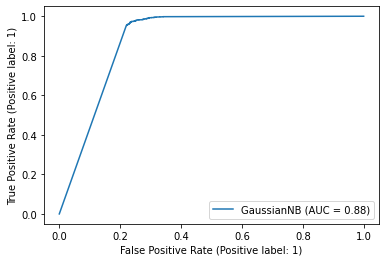

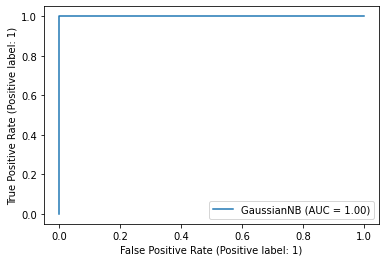

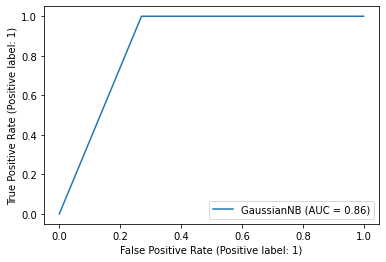

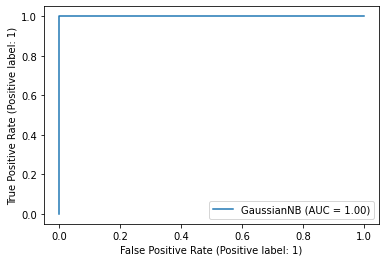

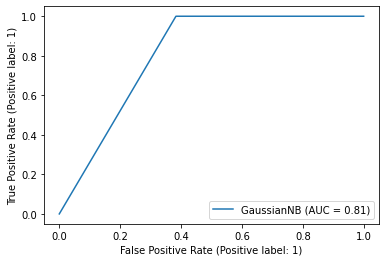

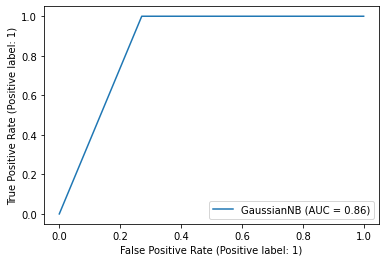

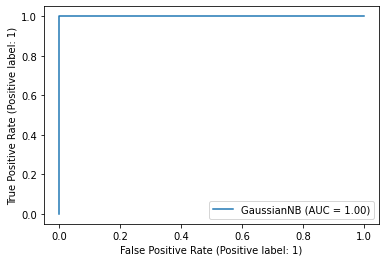

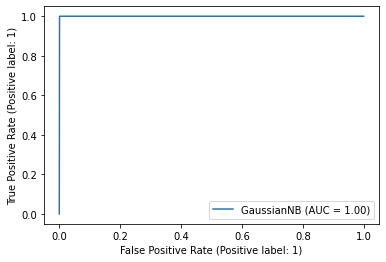

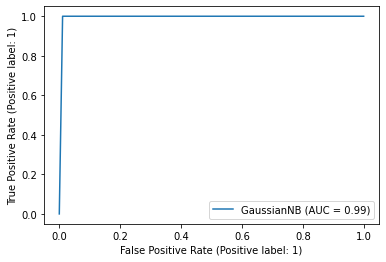

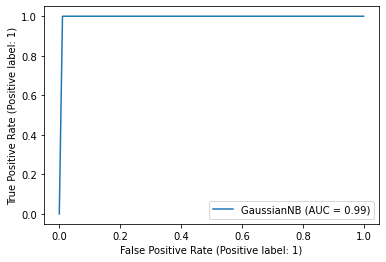

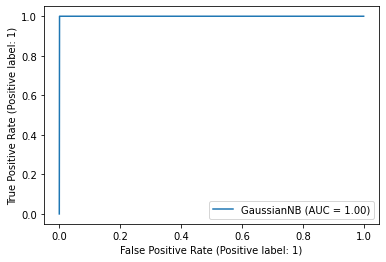

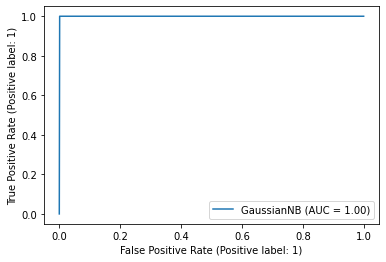

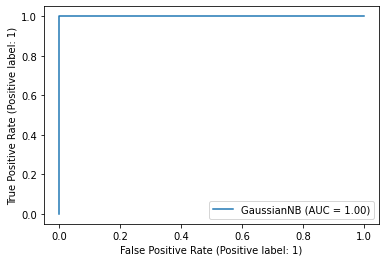

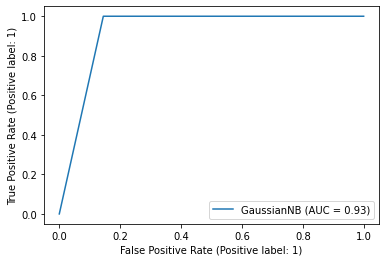

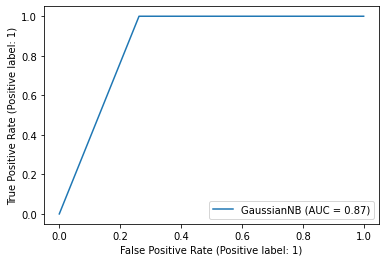

Overall efficiency:0.56


In [77]:
#import warnings
#warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", category=FutureWarning)
bayes_df = make_bayes_models(50)
bayes_classes = (list(bayes_df.columns.values))
total_sz = 0.0
correct_sz = 0.0

i = 0

for ind in bayes_df.index:

    total_sz += 1
    correct = True
    for c in bayes_classes:
      if bayes_df[c][ind] == '-':
        correct = False
        break
    if correct == True:
      correct_sz += 1

plt.show()
print("Overall efficiency:"+"{:.2f}".format(correct_sz / total_sz))

## XGBoost

In [78]:
def xgb_test(test_percentage):

    texts_train, texts_test, y_train, y_test = get_train_and_test("All", test_percentage)
    if len(texts_train) == 0:
        print ("Class entities amount is too small! Ignoring...")
        return [], [], []

    bow = bag_of_words(texts_train)
    X_train_bow = np.stack(list(map(bow.text_to_bow, texts_train)))
    X_test_bow  = np.stack(list(map(bow.text_to_bow, texts_test)))
    D_train     = xgb.DMatrix(X_train_bow, label=y_train)
    D_test      = xgb.DMatrix(X_test_bow, label=y_test)
    
    param = {
        'eta': 0.3, 
        'max_depth': 3,  
        'objective': 'multi:softprob',  
        'num_class': len(list(df.columns.values))} 

    steps = 20

    xgb_model = xgb.train(param, D_train, steps)


    preds = xgb_model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

xgb_test (50)

Precision = 0.4863035199891233
Recall = 0.3994890621351208
Accuracy = 0.8416


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Neural network processing

## Bert with pytorch

### Preprocessing

In [15]:
!pip install pytorch-lightning --quiet
!pip install transformers --quiet

In [16]:
!nvidia-smi

Tue Jan 18 13:11:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import transformers
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [19]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)

for column in df:
  if column != 'comment':
    if df[column].sum() > 1 and val_df[column].sum() == 0:
      index = train_df.loc[train_df[column] == 1].index[0]
      val_df = val_df.append(df.iloc[index])
      train_df.drop([index], inplace=True)

train_df.shape, val_df.shape

((4745, 16), (255, 16))

In [20]:
for column in df:
  if column != 'comment':
    print(train_df[column].sum(), val_df[column].sum())

2553 129
1 0
752 47
2 1
801 46
493 27
1 0
11 2
16 1
31 1
10 1
5 1
1 1
188 11
537 28


In [23]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
token_counts = []
MAX_TOKEN_COUNT = 512
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment"], 
    max_length=MAX_TOKEN_COUNT, 
    truncation=True
  ))
  token_counts.append(token_count)

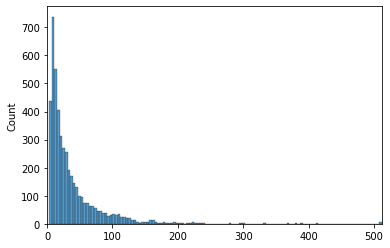

In [25]:
sns.histplot(token_counts)
plt.xlim([0, MAX_TOKEN_COUNT]);

### model

In [26]:
class CommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [27]:
train_dataset = CommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

In [28]:
class CommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = CommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = CommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [29]:
N_EPOCHS = 5
BATCH_SIZE = 8

data_module = CommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [30]:
class CommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [31]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [32]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(593, 2965)

In [33]:
LABEL_COLUMNS = df.columns.tolist()[1:]
model = CommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### training

In [34]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [35]:
!kill 329

/bin/bash: line 0: kill: (329) - No such process


In [36]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="/content/drive/MyDrive/best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [37]:
logger = TensorBoardLogger("lightning_logs", name="comments")

In [38]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [39]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [40]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 11.5 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.287   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 593: val_loss reached 0.14096 (best 0.14096), saving model to "/content/drive/MyDrive/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1187: val_loss reached 0.08170 (best 0.08170), saving model to "/content/drive/MyDrive/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 1781: val_loss reached 0.06727 (best 0.06727), saving model to "/content/drive/MyDrive/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 2375: val_loss reached 0.06519 (best 0.06519), saving model to "/content/drive/MyDrive/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 2969: val_loss reached 0.06141 (best 0.06141), saving model to "/content/drive/MyDrive/best-checkpoint.ckpt" as top 1


1

In [41]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.06140735372900963}
--------------------------------------------------------------------------------


[{'test_loss': 0.06140735372900963}]

### Predictions

In [42]:
trained_model = CommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = CommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/255 [00:00<?, ?it/s]

In [44]:
accuracy(predictions, labels, threshold=0.5)

tensor(0.9801)

In [70]:
from sklearn.metrics import classification_report

print("Classification metric per label\n")
for i, name in enumerate(LABEL_COLUMNS):
  a = 2
  s = sum(labels[:,i])
  if s > 0:
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    pred = (predictions[:, 0] > 0.5) * 1
    print(name)
    print(classification_report(labels[:,i], pred))

Classification metric per label

company-brand.general-satisfaction
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       126
           1       0.91      0.92      0.92       129

    accuracy                           0.91       255
   macro avg       0.91      0.91      0.91       255
weighted avg       0.91      0.91      0.91       255

company-brand.convenience
              precision    recall  f1-score   support

           0       0.69      0.41      0.51       208
           1       0.06      0.17      0.09        47

    accuracy                           0.36       255
   macro avg       0.37      0.29      0.30       255
weighted avg       0.57      0.36      0.43       255

attributes.size-fit
              precision    recall  f1-score   support

           0       1.00      0.49      0.66       254
           1       0.01      1.00      0.02         1

    accuracy                           0.49       255
   macro avg  